<a href="https://www.kaggle.com/code/ibkya12/m-hendislik-tasar-m-skin-lesion?scriptVersionId=186125012" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

SIZE=32

2024-06-29 19:48:30.253282: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-29 19:48:30.253402: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-29 19:48:30.340081: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
skin_df = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

In [3]:
skin_df.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))
 
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extr

/tmp/ipykernel_24/1477313381.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


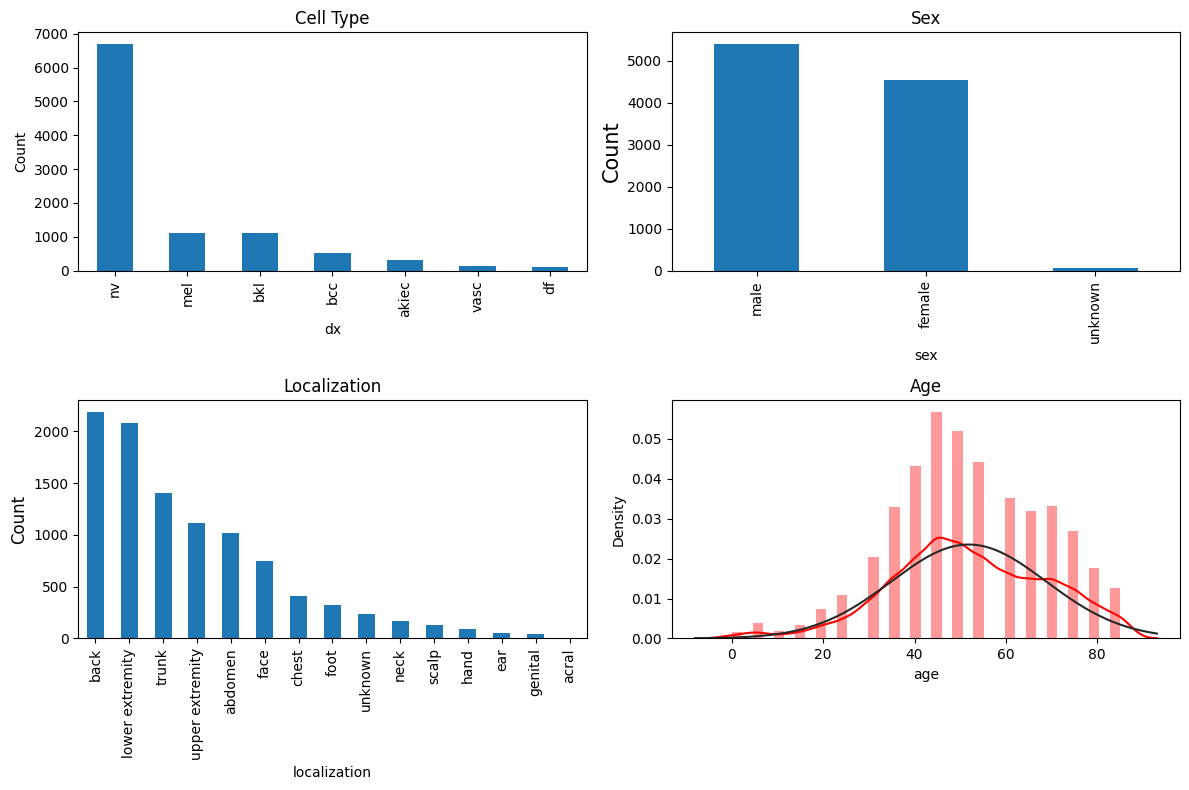

In [5]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()


In [6]:
from sklearn.utils import resample
print(skin_df['label'].value_counts())

label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64


In [7]:
df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

n_samples=500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)


In [8]:
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

In [9]:
print(skin_df_balanced['label'].value_counts())

label
0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: count, dtype: int64


In [10]:
base_skin_dir = os.path.join('/kaggle/input/skin-cancer-mnist-ham10000')
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [11]:
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

n_samples = 5 

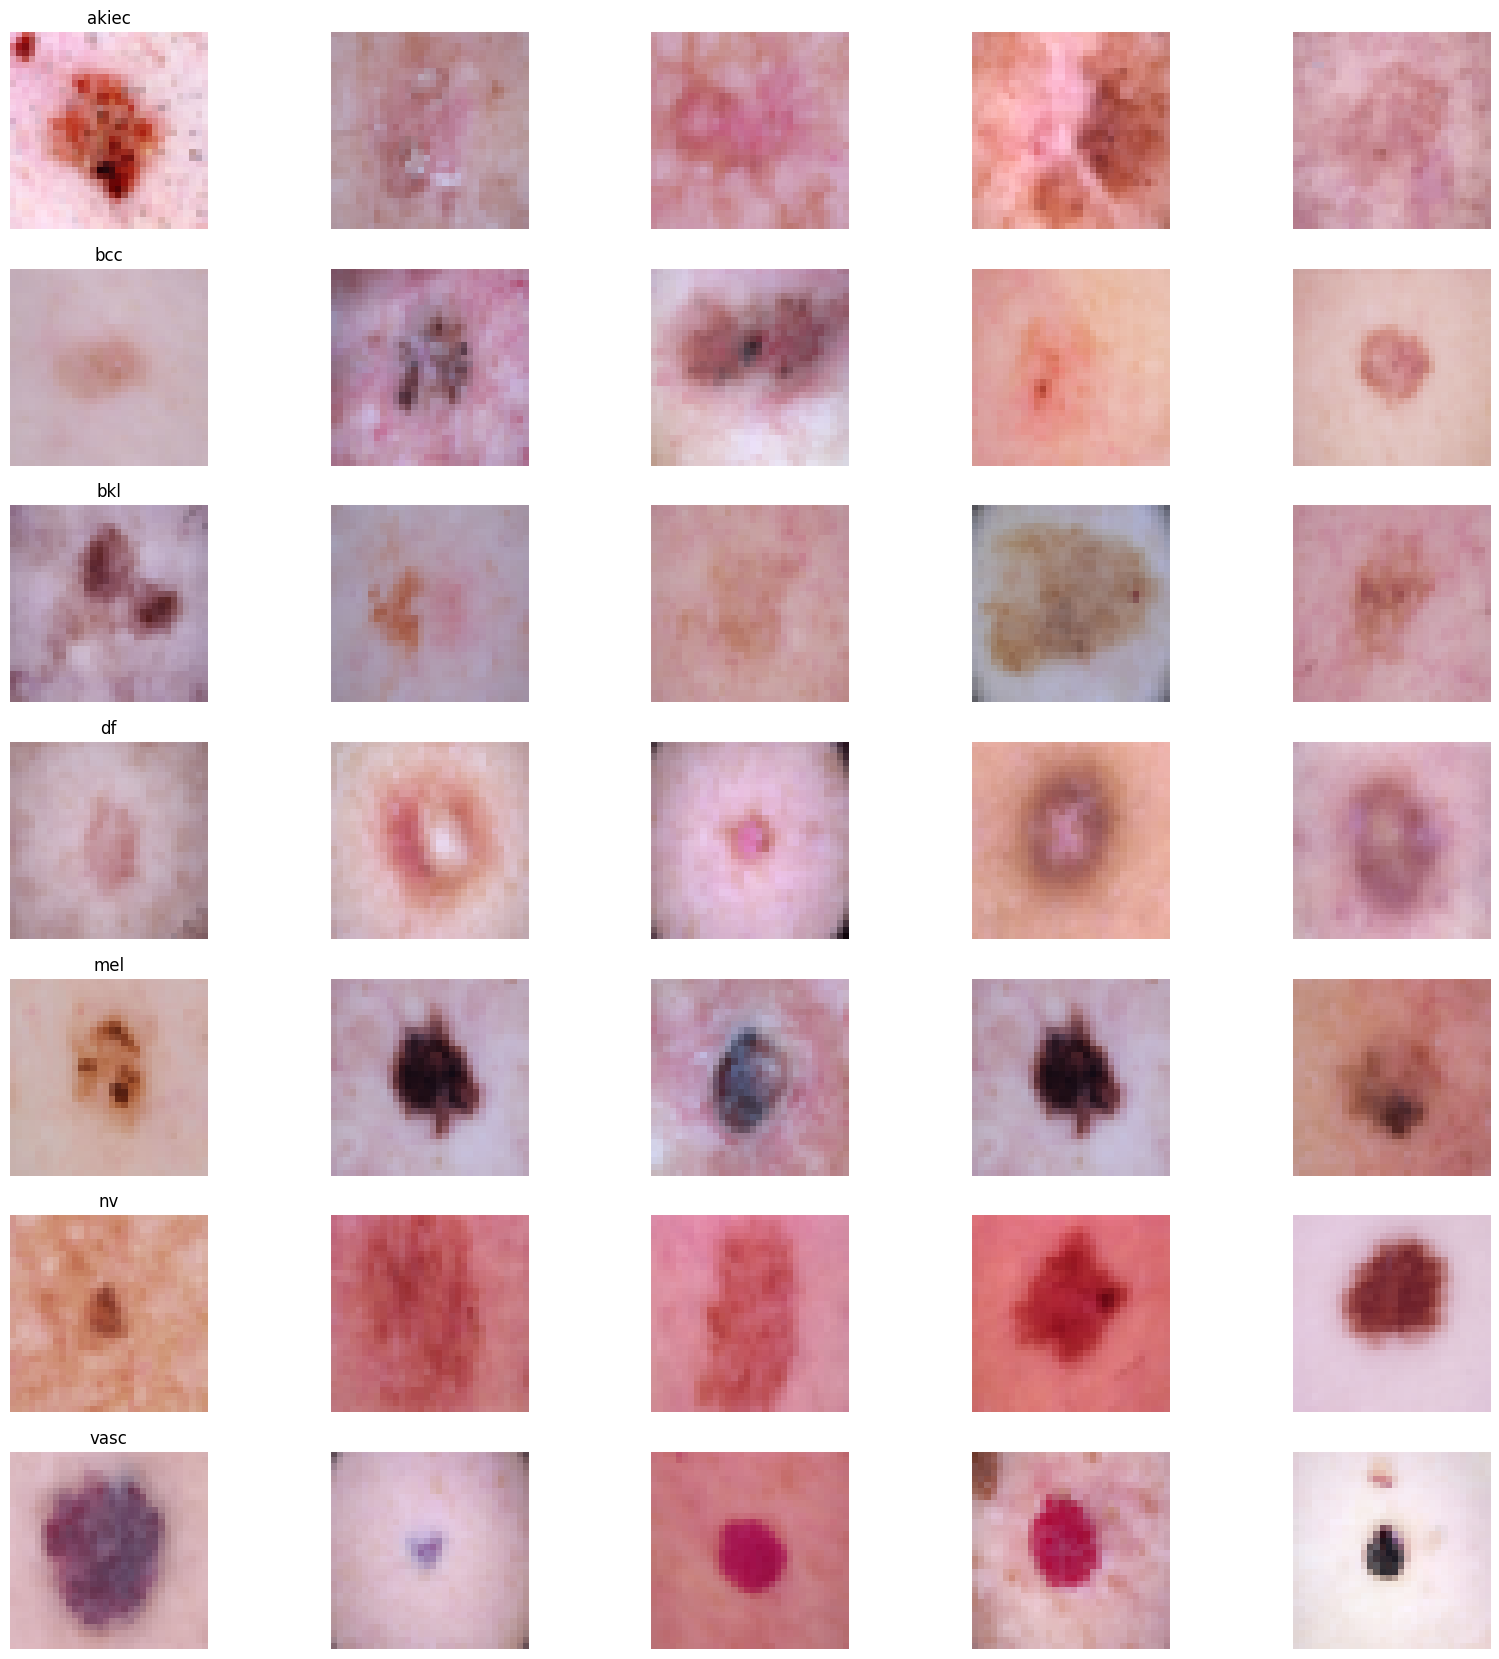

In [12]:
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')


In [13]:

X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  
Y=skin_df_balanced['label']  
Y_cat = to_categorical(Y, num_classes=7) 


x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

In [14]:
num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))

model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))

model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))

model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])



/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 256)    │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 384,455 (1.47 MB)

 Trainable params: 384,455 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150


I0000 00:00:1719690582.426740      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719690582.443354      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719690588.359237      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


165/165 - 18s - 108ms/step - acc: 0.1901 - loss: 1.8988 - val_acc: 0.2023 - val_loss: 1.8715
Epoch 2/150
165/165 - 1s - 4ms/step - acc: 0.2739 - loss: 1.7375 - val_acc: 0.3063 - val_loss: 1.6618
Epoch 3/150
165/165 - 1s - 4ms/step - acc: 0.3642 - loss: 1.5290 - val_acc: 0.3977 - val_loss: 1.4858
Epoch 4/150
165/165 - 1s - 4ms/step - acc: 0.4088 - loss: 1.4565 - val_acc: 0.4343 - val_loss: 1.3963
Epoch 5/150
165/165 - 1s - 4ms/step - acc: 0.4320 - loss: 1.4223 - val_acc: 0.4400 - val_loss: 1.3776
Epoch 6/150
165/165 - 1s - 4ms/step - acc: 0.4545 - loss: 1.3719 - val_acc: 0.4857 - val_loss: 1.3421
Epoch 7/150
165/165 - 1s - 4ms/step - acc: 0.4815 - loss: 1.3096 - val_acc: 0.4949 - val_loss: 1.2869
Epoch 8/150
165/165 - 1s - 4ms/step - acc: 0.5059 - loss: 1.2706 - val_acc: 0.4731 - val_loss: 1.2807
Epoch 9/150
165/165 - 1s - 4ms/step - acc: 0.5055 - loss: 1.2546 - val_acc: 0.5326 - val_loss: 1.2262
Epoch 10/150
165/165 - 1s - 4ms/step - acc: 0.5318 - loss: 1.1957 - val_acc: 0.4834 - val_l

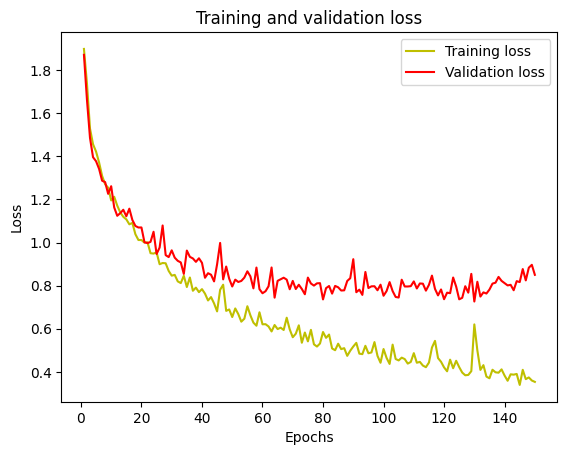

In [15]:
batch_size = 16 
epochs = 150

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
# Eğitimli modeli kaydet
model.save('skin_lesion_model.h5')

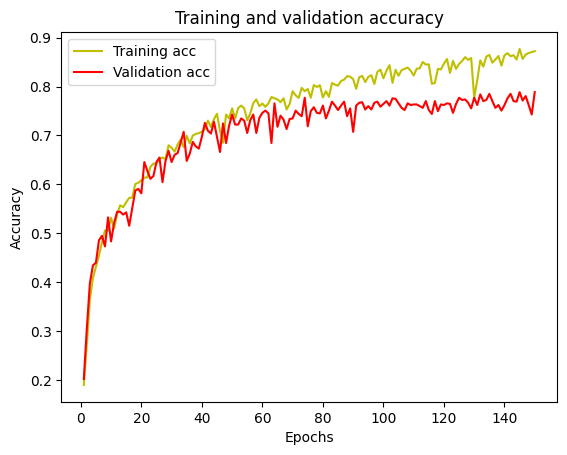

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Derin Öğrenme Modelimizin çıkarttığı özelliklerin, makine öğrenim modellerimiz sayesinde sınıflandırmak üzere özellikleri bir değişkene atayalım.

In [18]:
X_train_features = model.predict(x_train)
X_test_features = model.predict(x_test)

83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Text(0, 0.5, 'Fraction of incorrect predictions')

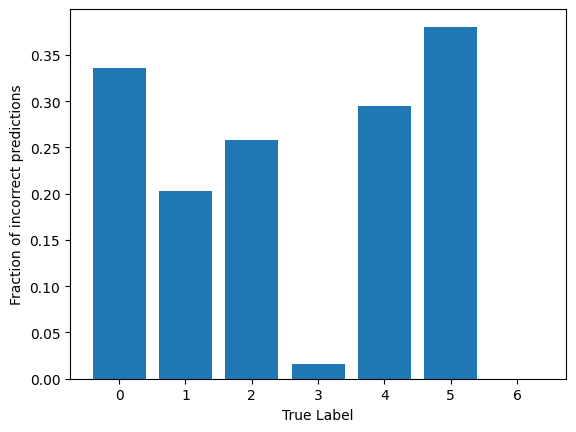

In [19]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 
cm = confusion_matrix(y_true, y_pred_classes)

incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')

In [20]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Neural Network
nn_model = MLPClassifier(random_state=42)
nn_model.fit(X_train_features, np.argmax(y_train, axis=1))
nn_preds = nn_model.predict(X_test_features)
print("Neural Network Accuracy: ", accuracy_score(np.argmax(y_test, axis=1), nn_preds))

# k-NN
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_features, np.argmax(y_train, axis=1))
knn_preds = knn_model.predict(X_test_features)
print("k-NN Accuracy: ", accuracy_score(np.argmax(y_test, axis=1), knn_preds))

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_features, np.argmax(y_train, axis=1))
lr_preds = lr_model.predict(X_test_features)
print("Logistic Regression Accuracy: ", accuracy_score(np.argmax(y_test, axis=1), lr_preds))

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_features, np.argmax(y_train, axis=1))
rf_preds = rf_model.predict(X_test_features)
print("Random Forest Accuracy: ", accuracy_score(np.argmax(y_test, axis=1), rf_preds))

# Detaylı sonuçlar
print("Neural Network Classification Report:\n", classification_report(np.argmax(y_test, axis=1), nn_preds))
print("k-NN Classification Report:\n", classification_report(np.argmax(y_test, axis=1), knn_preds))
print("Logistic Regression Classification Report:\n", classification_report(np.argmax(y_test, axis=1), lr_preds))
print("Random Forest Classification Report:\n", classification_report(np.argmax(y_test, axis=1), rf_preds))


Neural Network Accuracy:  0.7794285714285715
k-NN Accuracy:  0.7862857142857143
Logistic Regression Accuracy:  0.7817142857142857
Random Forest Accuracy:  0.792
Neural Network Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.68      0.76       149
           1       0.81      0.79      0.80       128
           2       0.61      0.68      0.65       120
           3       0.88      0.94      0.91       128
           4       0.62      0.71      0.66       112
           5       0.69      0.64      0.66       113
           6       0.98      1.00      0.99       125

    accuracy                           0.78       875
   macro avg       0.78      0.78      0.78       875
weighted avg       0.79      0.78      0.78       875

k-NN Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.70      0.78       149
           1       0.80      0.80      0.80       128
           

In [21]:
# Her sınıf için ROC eğrisini çizmek için sınıfları binarize edelim
n_classes = y_test.shape[1]
y_test_bin = label_binarize(np.argmax(y_test, axis=1), classes=range(n_classes))


In [22]:
# Neural Network Tahminleri
nn_y_pred = nn_model.predict_proba(X_test_features)
# k-NN Tahminleri
knn_y_pred = knn_model.predict_proba(X_test_features)
# Logistic Regression Tahminleri
lr_y_pred = lr_model.predict_proba(X_test_features)
# Random Forest Tahminleri
rf_y_pred = rf_model.predict_proba(X_test_features)

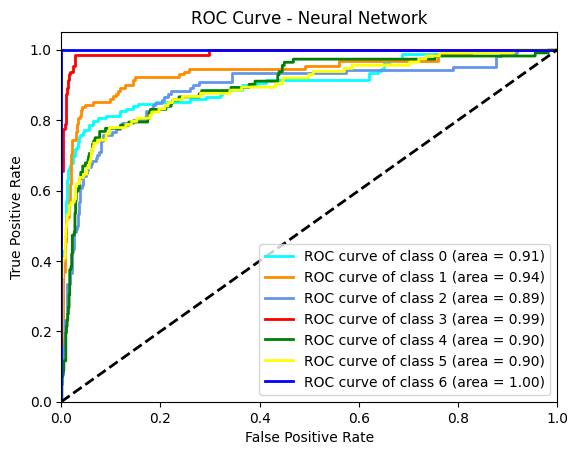

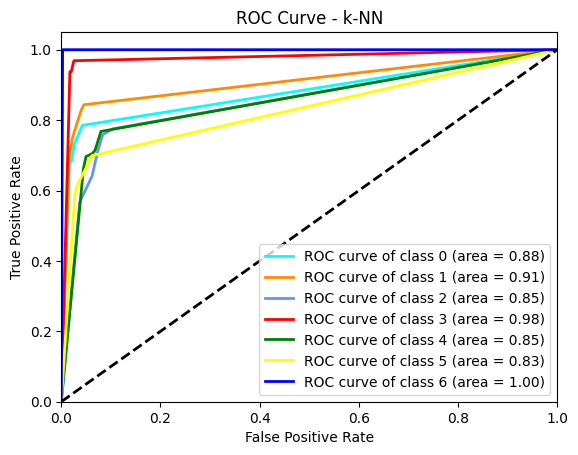

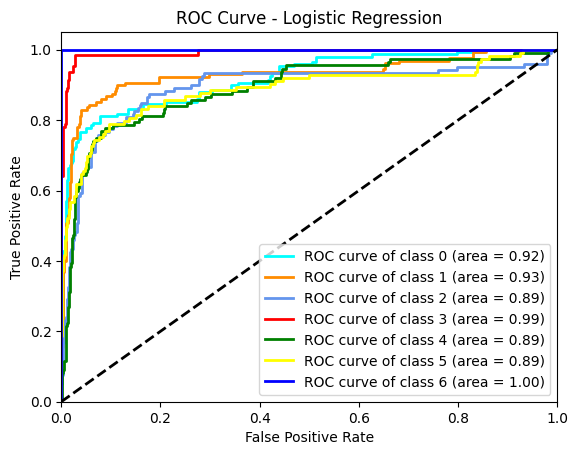

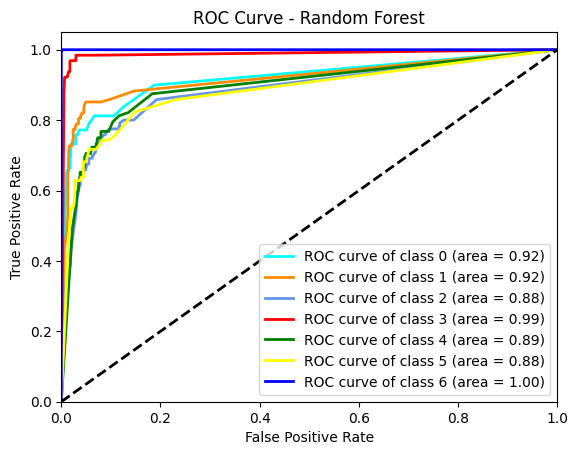

In [23]:
def plot_roc(y_test_bin, y_pred, n_classes, model_name):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'yellow', 'blue'])
    plt.figure()
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Neural Network ROC
plot_roc(y_test_bin, nn_y_pred, n_classes, "Neural Network")
# k-NN ROC
plot_roc(y_test_bin, knn_y_pred, n_classes, "k-NN")
# Logistic Regression ROC
plot_roc(y_test_bin, lr_y_pred, n_classes, "Logistic Regression")
# Random Forest ROC
plot_roc(y_test_bin, rf_y_pred, n_classes, "Random Forest")